In [6]:
#!pip3 install -U -r requirements.txt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [10]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

100%|██████████| 170M/170M [00:02<00:00, 80.1MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [11]:
data_variance = np.var(training_data.data / 255.0)

In [12]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [13]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [14]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [15]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [16]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

## Train

In [17]:
batch_size = 256
num_training_updates = 5000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [18]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

In [19]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [20]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [21]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [23]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 1.001
perplexity: 1.000

200 iterations
recon_error: 0.986
perplexity: 1.000

300 iterations
recon_error: 0.976
perplexity: 1.000

400 iterations
recon_error: 0.980
perplexity: 1.000

500 iterations
recon_error: 0.992
perplexity: 1.002

600 iterations
recon_error: 0.993
perplexity: 1.730

700 iterations
recon_error: 0.515
perplexity: 2.275

800 iterations
recon_error: 0.321
perplexity: 3.185

900 iterations
recon_error: 0.261
perplexity: 5.124

1000 iterations
recon_error: 0.235
perplexity: 7.823

1100 iterations
recon_error: 0.223
perplexity: 8.754

1200 iterations
recon_error: 0.201
perplexity: 11.479

1300 iterations
recon_error: 0.179
perplexity: 14.566

1400 iterations
recon_error: 0.174
perplexity: 16.897

1500 iterations
recon_error: 0.162
perplexity: 18.739

1600 iterations
recon_error: 0.151
perplexity: 20.849

1700 iterations
recon_error: 0.148
perplexity: 21.899

1800 iterations
recon_error: 0.140
perplexity: 23.079

1900 iterations
recon_error: 0

## Plot Loss

In [24]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/vqvae_model.pth")

In [25]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

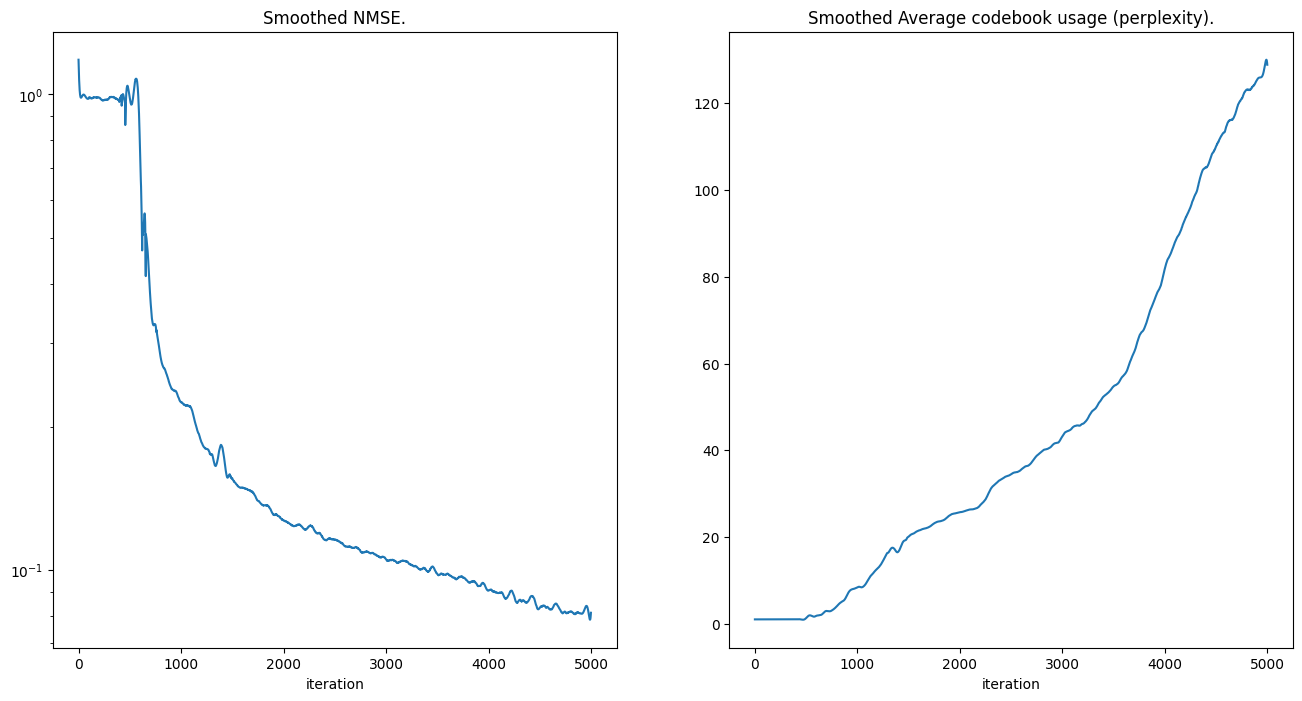

In [26]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [27]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [28]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [29]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

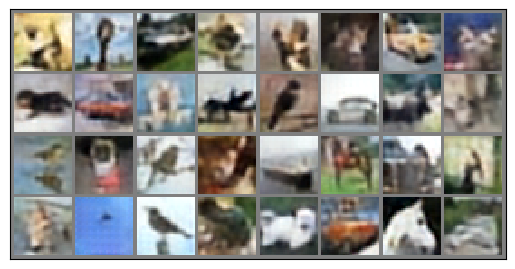

In [30]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

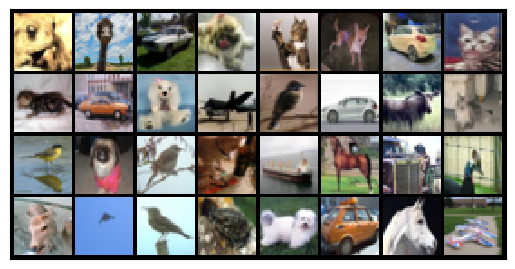

In [31]:
show(make_grid(valid_originals.cpu()+0.5))

In [32]:
import torch
import torch.nn.functional as F

def psnr(img1, img2, max_val=1.0):
    """
    Compute the PSNR (Peak Signal-to-Noise Ratio) between two images.
    Args:
        img1: Tensor of shape (N, C, H, W), normalized [0, max_val]
        img2: Tensor of shape (N, C, H, W), normalized [0, max_val]
        max_val: Maximum pixel value (default: 1.0 for normalized images)
    Returns:
        psnr: PSNR value (higher is better)
    """
    mse = F.mse_loss(img1, img2, reduction='mean')  # Mean Squared Error
    psnr_value = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr_value


In [33]:
from torchvision.transforms.functional import gaussian_blur

def ssim(img1, img2, window_size=11, max_val=1.0):
    """
    Compute the SSIM (Structural Similarity Index) between two images.
    Args:
        img1: Tensor of shape (N, C, H, W), normalized [0, max_val]
        img2: Tensor of shape (N, C, H, W), normalized [0, max_val]
        window_size: Gaussian kernel size for smoothing (default: 11)
        max_val: Maximum pixel value (default: 1.0 for normalized images)
    Returns:
        ssim: SSIM value (higher is better, max is 1.0)
    """
    mu1 = gaussian_blur(img1, kernel_size=window_size)
    mu2 = gaussian_blur(img2, kernel_size=window_size)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = gaussian_blur(img1 ** 2, kernel_size=window_size) - mu1_sq
    sigma2_sq = gaussian_blur(img2 ** 2, kernel_size=window_size) - mu2_sq
    sigma12 = gaussian_blur(img1 * img2, kernel_size=window_size) - mu1_mu2

    c1 = (0.01 * max_val) ** 2
    c2 = (0.03 * max_val) ** 2

    ssim_map = ((2 * mu1_mu2 + c1) * (2 * sigma12 + c2)) / ((mu1_sq + mu2_sq + c1) * (sigma1_sq + sigma2_sq + c2))
    return ssim_map.mean()


In [34]:
psnr_value = psnr(valid_reconstructions, valid_originals)
ssim_value = ssim(valid_reconstructions, valid_originals)
print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

PSNR: 23.37, SSIM: 0.7491


##Transformer encoder

In [35]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, num_channels, seq_len, num_heads=8, hidden_dim=128, num_layers=4):
        super(TransformerModel, self).__init__()
        self.num_channels = num_channels
        self.seq_len = seq_len
        self.embedding = nn.Linear(num_channels, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, hidden_dim))
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim * 4
        )
        self.output_layer = nn.Linear(hidden_dim, num_channels)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)  # Shape: (B, Seq, C)
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]  # Add positional encoding
        x = self.transformer(x, x)  # Self-attention
        x = self.output_layer(x)  # Project back to original channel dimension
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)  # Reshape to original shape
        return x

# Example usage
model = TransformerModel(num_channels=64, seq_len=64)
example_input = torch.randn(32, 64, 8, 8)  # Input shape (Batch, Channels, Height, Width)
output = model(example_input)
print(output.shape)  # Output shape should match input: (32, 64, 8, 8)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


torch.Size([32, 64, 8, 8])


In [36]:
  vqvae = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)
  vqvae.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/vqvae_model.pth'))
  vqvae.eval()

<ipython-input-36-44611cad7c4f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/vqvae_model.pth'))


Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (_vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 64)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): Module

In [37]:
model = TransformerModel(num_channels=64, seq_len=64)

In [38]:
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = vqvae._pre_vq_conv(vqvae._encoder(valid_originals))
_, valid_quantize, _, _ = vqvae._vq_vae(vq_output_eval)

In [39]:
valid_quantize.shape

torch.Size([32, 64, 8, 8])

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_shape=(64, 8, 8), num_classes=10):
        super(MLPModel, self).__init__()
        # Flatten the input
        input_dim = input_shape[0] * input_shape[1] * input_shape[2]  # 64 * 8 * 8 = 4096

        # Define MLP layers
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Flatten input tensor
        x = x.reshape(x.size(0), -1)  # Shape: (Batch, 64*8*8)

        # Forward pass through MLP
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for output layer (for use with CrossEntropyLoss)
        return x

In [41]:
mlp_model = MLPModel()

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

class CombinedModel(nn.Module):
    def __init__(self, vqvae_model, transformer_model, mlp_model):
        super(CombinedModel, self).__init__()
        self.vqvae = vqvae_model
        self.transformer = transformer_model
        self.mlp = mlp_model

    def forward(self, x):
        # Pass input through VQ-VAE to get latent representation
        vq_output_eval = self.vqvae._pre_vq_conv(vqvae._encoder(x))
        _, quantized, _, _ = self.vqvae._vq_vae(vq_output_eval)  # Assuming _vq_vae outputs (B, C, H, W)
        # Pass latent representation through Transformer
        batch_size, channels, height, width = quantized.shape
        # print(quantized.shape)

        transformer_output = self.transformer(quantized)
        output = self.mlp(transformer_output)
        # print(output.shape)
        return output

# Example usage
# Assuming vqvae_model is your VQ-VAE instance
# transformer_model is the TransformerModel instance created above
combined_model = CombinedModel(vqvae, model, mlp_model)

# Define optimizer and loss
optimizer = optim.Adam(combined_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Move model to the selected device
vqvae = vqvae.to(device)
model = model.to(device)
mlp_model = mlp_model.to(device)
combined_model = combined_model.to(device)
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    for batch in training_loader:
        # Assuming batch is a tuple of (inputs, targets)
        inputs, targets = batch  # Unpack the tuple
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Assuming targets is a tensor of shape (batch_size,) with class indices
        # num_classes = 10  # CIFAR-10 has 10 classes
        # targets_one_hot = F.one_hot(targets, num_classes=num_classes)

        # Convert one-hot encoded tensor to the same data type as inputs
        # targets_one_hot = targets_one_hot.to(torch.float32)
        # print(targets_one_hot.shape)
        # print(targets.shape)

        optimizer.zero_grad()

        # Forward pass
        outputs = combined_model(inputs)
        # print(outputs.shape)

        loss = loss_fn(outputs, targets)



        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/100], Loss: 1.5963
Epoch [2/100], Loss: 1.7386
Epoch [3/100], Loss: 1.6757
Epoch [4/100], Loss: 1.8526
Epoch [5/100], Loss: 1.7134
Epoch [6/100], Loss: 2.0082
Epoch [7/100], Loss: 1.8452
Epoch [8/100], Loss: 1.8069
Epoch [9/100], Loss: 1.8569
Epoch [10/100], Loss: 1.7275
Epoch [11/100], Loss: 1.6731
Epoch [12/100], Loss: 1.9358
Epoch [13/100], Loss: 1.8341
Epoch [14/100], Loss: 1.8366
Epoch [15/100], Loss: 1.7504
Epoch [16/100], Loss: 1.5938
Epoch [17/100], Loss: 1.6220
Epoch [18/100], Loss: 1.5361
Epoch [19/100], Loss: 1.6423
Epoch [20/100], Loss: 1.5922
Epoch [21/100], Loss: 1.9216
Epoch [22/100], Loss: 1.9637
Epoch [23/100], Loss: 2.1204
Epoch [24/100], Loss: 2.3421
Epoch [25/100], Loss: 2.2704
Epoch [26/100], Loss: 2.2819
Epoch [27/100], Loss: 2.2732
Epoch [28/100], Loss: 2.2704
Epoch [29/100], Loss: 2.2212
Epoch [30/100], Loss: 2.2777
Epoch [31/100], Loss: 2.2914
Epoch [32/100], Loss: 2.3046
Epoch [33/100], Loss: 2.2976
Epoch [34/100], Loss: 2.3024
Epoch [35/100], Loss: 2

KeyboardInterrupt: 